To create an anaconda env to run this code:

```
$ conda create -n demo pandas requests seaborn jupyter pyyaml
```

In [1]:
%matplotlib inline

import datetime
import requests
import pandas as pd
import seaborn
import yaml

from dateutil.parser import parse

The YML config file contains the target host and the API credentials. For example:

```
url: https://ooinet-dev-01.oceanobservatories.org
apiname: OOIAPI-XXXXXXXXXXX
apikey: XXXXXXXXXXXX
```

In [2]:
config = yaml.load(open('config_test.yml'))
ntp_diff = (datetime.datetime(1970, 1, 1) - datetime.datetime(1900, 1, 1)).total_seconds()

These are some helper functions to transform an OOI JSON response into a pandas dataframe.

In [3]:
def clean_time(t):
    if isinstance(t, basestring):
        t = parse(t)
    t = t.replace(microsecond=0)
    return t.isoformat() +  '.000Z'

def clean_params(params):
    if 'parameters' in params:
        parameters = params['parameters']
        if isinstance(parameters, basestring):
            parameters = {int(p) for p in parameters.split(',')}
        elif isinstance(parameters, (list, tuple)):
            parameters = set(parameters)
        elif isinstance(parameters, int):
            parameters = {parameters}
        
        parameters.add(7)
        params['parameters'] = ','.join((str(p) for p in parameters))
    
    if 'beginDT' in params:
        params['beginDT'] = clean_time(params['beginDT'])
        
    if 'endDT' in params:
        params['endDT'] = clean_time(params['endDT'])
        
    if 'limit' not in params:
        params['limit'] = 2000
        
    return params
    
def get_data(subsite, node, sensor, method, stream, **params):
    url = '{host_url}/api/m2m/12576/sensor/inv/{subsite}/{node}/{sensor}/{method}/{stream}'.format(
        host_url=config['url'],
        subsite=subsite,
        node=node,
        sensor=sensor,
        method=method,
        stream=stream
    )
    params = clean_params(params)
        
    data = requests.get(url, params=params, auth=(config['apiname'], config['apikey']), verify=False).json()
    return data

def get_dataframe(subsite, node, sensor, method, stream, **params):
    data = get_data(subsite, node, sensor, method, stream, **params)
    df = pd.DataFrame(data)
    del df['pk']
    df['time'] = pd.to_datetime(df.time - ntp_diff, unit='s')
    df = df.set_index(df.time)
    del df['time']
    return df

## Issue #4390 - Unable to calculate dissolved oxygen from surface mounted DOSTA

Note, this fix has already been deployed to production.

In [4]:
subsite, node, sensor = 'GA01SUMO-SBD11-04-DOSTAD000'.split('-', 2)
method, stream = 'telemetered', 'dosta_abcdjm_dcl_instrument'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=14,
                   beginDT='2016-12-01',
                   endDT='2016-12-11'
                   )

/Users/petercable/miniconda2/envs/s7demo/lib/python2.7/site-packages/requests/packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


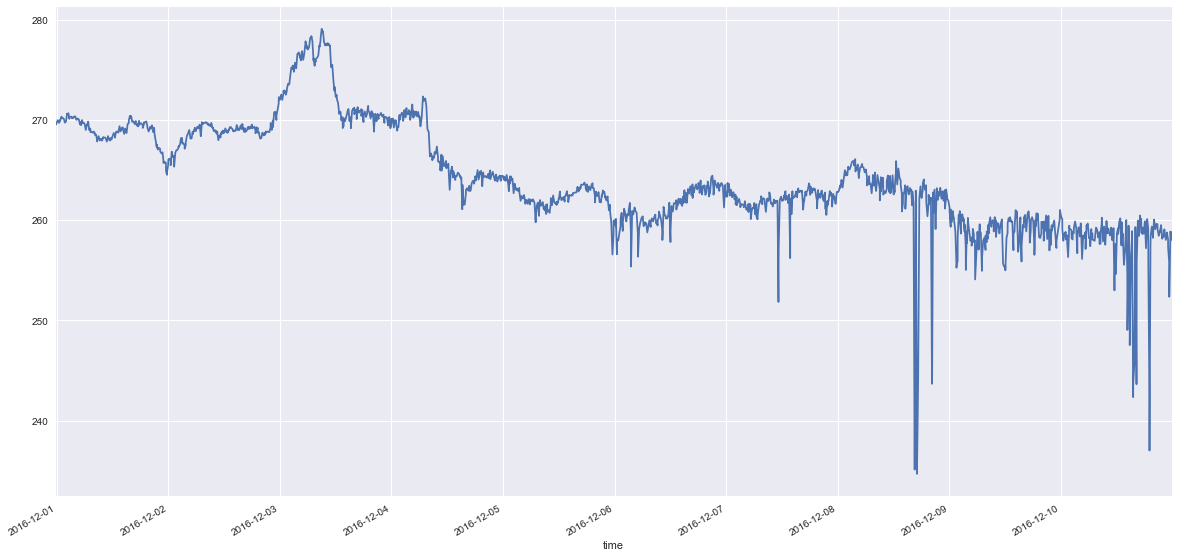

In [5]:
df.dissolved_oxygen.plot(figsize=(20, 10))

## Issue #3386 BOTPT compass lookup function has no default value, results in blowing up during execution

In [6]:
subsite, node, sensor = 'RS03CCAL-MJ03F-05-BOTPTA301'.split('-', 2)
method, stream = 'streamed', 'botpt_lily_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=1000,
                   parameters=(1133,312),
                   beginDT='2016-07-01 00:00:00',
                   endDT='2016-07-01 00:00:10'
                   )

/Users/petercable/miniconda2/envs/s7demo/lib/python2.7/site-packages/requests/packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [7]:
df

,corrected_compass_direction,corrected_compass_direction_qc_executed,corrected_compass_direction_qc_results,serial_number
time,,,,
2016-07-01 00:00:00,NaN,29,12,CORRUPT
2016-07-01 00:00:01,346.0,29,13,N9676
2016-07-01 00:00:02,346.0,29,13,N9676
2016-07-01 00:00:03,346.0,29,13,N9676
2016-07-01 00:00:04,346.0,29,13,N9676
2016-07-01 00:00:05,346.0,29,13,N9676
2016-07-01 00:00:06,346.0,29,13,N9676
2016-07-01 00:00:07,346.0,29,13,N9676
2016-07-01 00:00:08,346.0,29,13,N9676


## Issue 8655 CTD seawater_pressure data off by 50 dbar

In [8]:
subsite, node, sensor = 'RS03AXBS-LJ03A-12-CTDPFB301'.split('-', 2)
method, stream = 'streamed', 'ctdpf_optode_sample'
df = get_dataframe(subsite, node, sensor, method, stream,
                   limit=4000,
                   parameters=909,
                   beginDT='2016-07-01 00:00:00',
                   endDT='2016-08-01 00:00:10'
                   )

/Users/petercable/miniconda2/envs/s7demo/lib/python2.7/site-packages/requests/packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


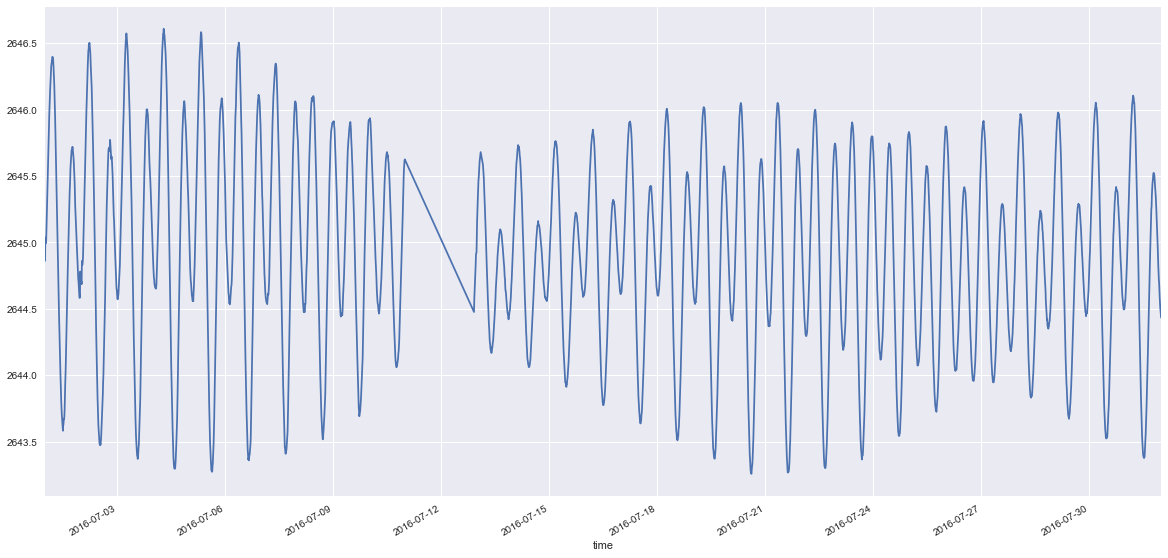

In [9]:
df.seawater_pressure.plot(figsize=(20, 10))